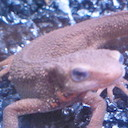

In [1]:
using Images, TestImages

img = load("imori.jpg")

## Q.1. チャネル入れ替え
画像を読み込み、RGBをBGRの順に入れ替えよ。

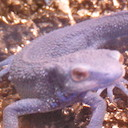

In [2]:
toBGR(rgb) = RGB(rgb.b, rgb.g, rgb.r)
toBGR.(img)

## Q.2. グレースケール化
画像をグレースケールにせよ。 グレースケールとは、画像の輝度表現方法の一種であり下式で計算される。
$$
Y = 0.2126 R + 0.7152 G + 0.0722 B
$$

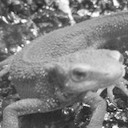

In [3]:
gray(rgb) = Gray(0.2126*rgb.r + 0.7152*rgb.g + 0.0722*rgb.b)
gray.(img)

## Q.3. 二値化
画像を二値化せよ。 二値化とは、画像を黒と白の二値で表現する方法である。 ここでは、グレースケールにおいて閾値を128に設定し、下式で二値化する。
```
y = { 0 (if y < 128)
     255 (else)
```

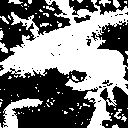

In [4]:
binary(rgb) = gray(rgb) < 128/255 ? Gray(0) : Gray(1)
binary.(img)

## Q.4. 大津の二値化
大津の二値化を実装せよ。 大津の二値化とは判別分析法と呼ばれ、二値化における分離の閾値を自動決定する手法である。 これは**クラス内分散**と**クラス間分散**の比から計算される。

* 閾値 $t$ 未満をクラス $0$, $t$ 以上をクラス $1$ とする。
* $w_0, w_1 ...$ 閾値 $t$ により分離された各クラスの画素数の割合 ($w_0 + w_1 = 1$ を満たす)
* $S_0^2, S_1^2 ...$ 各クラスの画素値の分散
* $M_0, M_1 ...$ 各クラスの画素値の平均値

とすると、

クラス内分散 $$
S^2_w = w_0 S_0^2 + w_1 S_1^2
$$
クラス間分散 $$
\begin{align}
S^2_b &= w_0 (M_0 - M_1)^2 + w_1 (M_1 - M_t)^2 \\
      &= w_0 w_1 (M_0 - M_1)^2
\end{align}
$$
画像全体の画素の分散 $$
S_t^2 = S_w^2 + S_b^2 = (const)
$$
となり、分離度 X は次式で定義される。

分離度 $$
    X = \frac{S_b^2}{S_{in}^2} = \frac{S_b^2}{S^2 - S_b^2}
$$
となるので、$$
argmax_t X = argmax_t S_b^2
$$
となる。

すなわち、$S_b^2 = w_0 w_1 (M_0 - M_1)^2$ が最大となる、閾値$t$を二値化の閾値とすれば良い。

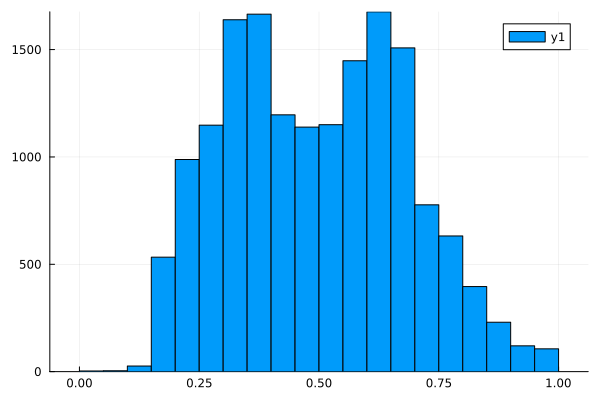

In [5]:
using Plots
histogram(gray.(img) |> g -> getfield.(g, :val) |> vec)

In [57]:
module MyOtsu
import Images: Gray

mean(v) = sum(v) / length(v)
var(v) = begin
    m = mean(v)
    s = 0
    for x in v
        s += (x - m)^2
    end
    s / length(v)
end


function test(img, t)
    V₀ = filter(x -> x > t, img)
    V₁ = filter(x -> x <= t, img)
    w₀, w₁ = length.([V₀, V₁]) / length(img)
    M₀, M₁ = mean.([V₀, V₁])
    #S₀², S₁² = var.([V₀, V₁])
    #S²w = w₀*S₀² + w₁*S₁²
    S²b = w₀*w₁ * (M₀ - M₁)^2
end

gray(c, t) = c > t ? Gray(1) : Gray(0) 

function binary(img)
    max, maxₜ = 0, 0
    for t in 0:0.01:1
        result = test(img, t)
        if result > max
            max, maxₜ = result, t
        end
    end
    @show maxₜ
    gray.(img, maxₜ)
end

end

Main.MyOtsu

maxₜ = 0.5


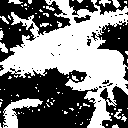

In [58]:
MyOtsu.binary(gray.(img))